In [1]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split

%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, utils
import cv2

from google.colab import files ### file.download() to download a file from colab instead of right clicking

In [2]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
path = 'drive/MyDrive/Colab Notebooks/CSS 433/data'
for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy


In [18]:
### Loading the data
### loading the labels, basically the 2 hour GHI forecast
y = torch.from_numpy(np.load(os.path.join(path, 'labels.npy')))
### loading the labels, basically the ture GHI values
ground_truth = torch.from_numpy(np.load(os.path.join(path, 'ground_truth.npy')))
### loading the time at which the images were taken
### the time also corresposnds to the meteo data and the groun truth value
time = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)
### Loading the X file, the file that contains the images
### this file has almost 11000 pair of images. each image has a size of 250x250x3
### so this X file has a shape of  10693,2,250,250,3
X = np.load(os.path.join(path, 'X.npy'),mmap_mode='c')
print(X.shape)

(10693, 2, 250, 250, 3)


<Figure size 2000x400 with 0 Axes>

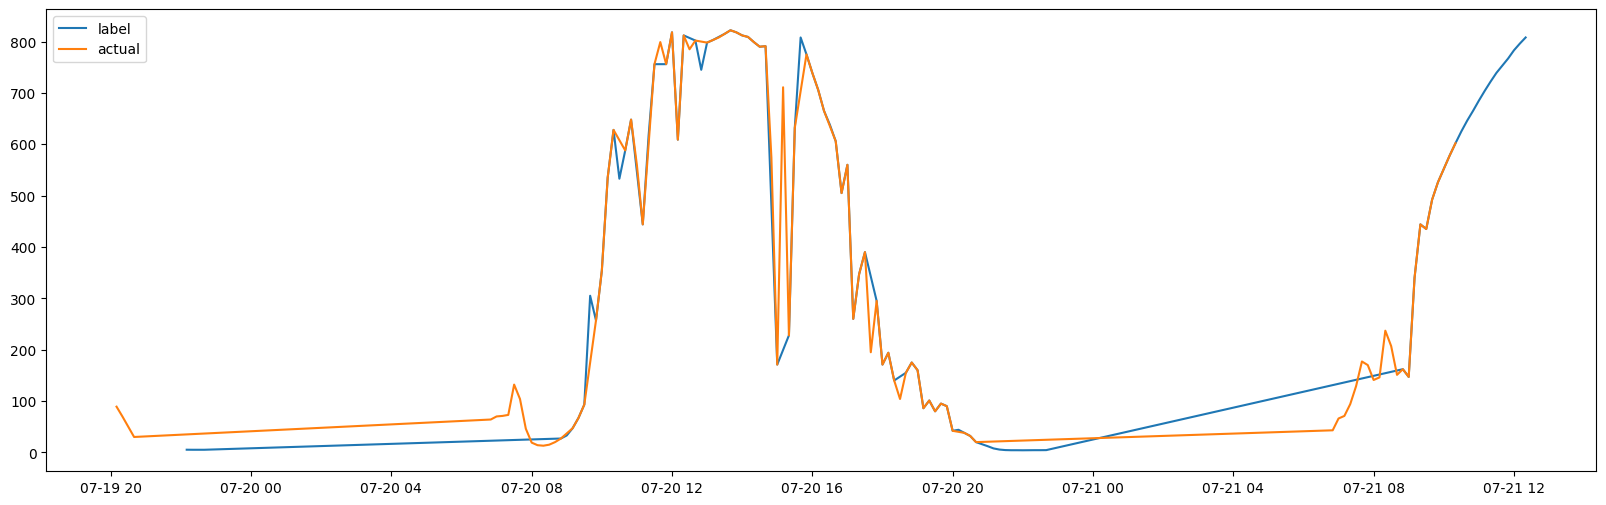

In [ ]:
plt.figure(figsize=(20,4))
a = 4400
interval = (a,a+100)
delta = datetime.timedelta(hours=2)
plt.figure(figsize=(20,6))
plt.plot(time[interval[0]:interval[1]]+delta,y[interval[0]:interval[1]], label='label')
plt.plot(time[interval[0]:interval[1]],ground_truth[interval[0]:interval[1]], label='actual')
plt.legend()
plt.show()

In [ ]:
### if you want to resize the images to a certain size (here i chose (64,64)) but you can change it
dimensions = (64,64)
X_reduced = np.empty((X.shape[0],X.shape[1],dimensions[0],dimensions[1],3),dtype=int)

for i in [0,1]:
  for j in range(X.shape[0]):
    X_reduced[j,i] = cv2.resize(X[j,i,:,:,:], dimensions)

In [ ]:
X = X_reduced

In [ ]:
### Here i split the data into training and testing in a custom way
### we take a random sample of 400 (we can change it of course) images from the middle.
### that is we have a total of X images, I choose randomly a set of images not necessarly at the end and we train
### on everything else and we test on this selected batch (selected from the middle)
### maybe on google you might see a function called train_test_split
### we dont want to use it as this splits the data completely randomly which means we will loose
### the time series effect of the data s it shuffles the data then splits it

### how many images to test on
split_at_add = 400
### some random place to split the data at
### i would like you to choose one of these mainly 1270, 4000 and 7900
### feel free to choose other values for split_at to test different test sets
split_at = 1270
y_train = torch.tensor(tuple(y[:len(X)][:split_at])+tuple(y[:len(X)][split_at+split_at_add:]))
y_test = y[:len(X)][split_at:split_at+split_at_add]

X_train = torch.from_numpy(np.array(tuple(X[:len(X)][:split_at]) + tuple(X[:len(X)][split_at+split_at_add:])))
X_test = torch.from_numpy(X[:len(X)][split_at:split_at+split_at_add])

print("Training: ", X_train.shape,y_train.shape)
print("Testing: ", X_test.shape,y_test.shape)

Training:  torch.Size([10293, 2, 64, 64, 3]) torch.Size([10293])
Testing:  torch.Size([400, 2, 64, 64, 3]) torch.Size([400])


In [3]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, transform_input=None, transform_label=None):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            transform_input (callable, optional): Optional transform to be applied on a sample. .
            transform_label (callable, optional): Optional transform to be applied on the label.
        """

        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels)))
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')
        self.transform_input = transform_input
        self.transform_label = transform_label

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        if self.transform_input:
            image0 = self.transform_input(image0)
            image1 = self.transform_input(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        return image0,image1,labels

In [4]:
def sample_display(image_web1, image_web2, label):
  plt.imshow(image_web1.permute(1,2,0))
  print(label.item())

In [5]:
trans = transforms.Compose([transforms.ToPILImage(),transforms.Resize(100),transforms.ToTensor()])

0 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
133.0
1 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
127.0
2 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
140.0
3 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
141.0


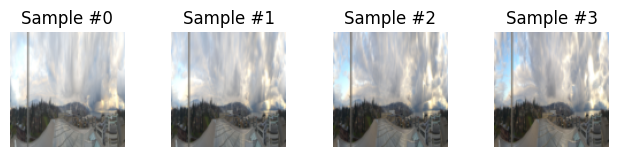

In [6]:
ghi_dataset = GHIDataset(path,'labels.npy','X.npy',trans)

for i, sample in enumerate(ghi_dataset):
    print(i, sample[0].shape, sample[1].shape, sample[2].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    sample_display(*sample)

    if i == 3:
        plt.show()
        break

In [24]:
len(ghi_dataset)
print(ghi_dataset[0][2])

tensor(133., dtype=torch.float64)


In [26]:
split_at_add = 400
### some random place to split the data at
### i would like you to choose one of these mainly 1270, 4000 and 7900
### feel free to choose other values for split_at to test different test sets
split_at = 1270


dataset_train, dataset_test = train_test_split(ghi_dataset, test_size = 0.15, shuffle = False)
dataset_train, dataset_val = train_test_split(dataset_train,test_size=0.15,shuffle=False)

print("Training  : ", len(dataset_train))
print("Validation: ", len(dataset_val))
print("Testing   : ", len(dataset_test))

Training  :  7725
Validation:  1364
Testing   :  1604


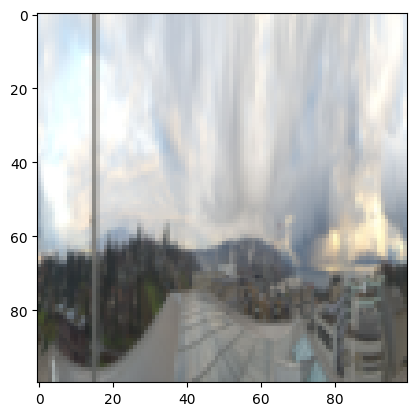

In [30]:
plt.imshow(dataset_train[0][0].permute(1,2,0))

In [7]:
def train_val_dataset(dataset, val_split=0.15,test_split=0.15):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

In [8]:
ghi_train, ghi_val, ghi_test = train_val_dataset(ghi_dataset)

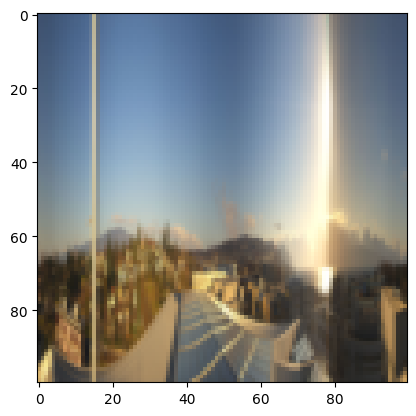

In [9]:
plt.imshow(ghi_train[1023][0].permute(1,2,0))

In [21]:
train_loader = DataLoader(ghi_train,
                        batch_size = 32,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        drop_last=False,
                        num_workers=2)

In [22]:
for batch_idx, sample in enumerate(train_loader):
  print(sample[2])
  if batch_idx > 0:
    break



tensor([133.0000, 127.0000, 140.0000, 141.0000, 134.0000, 115.0000, 143.0000,
        204.0000, 405.0000, 200.0000, 244.0000, 152.0000, 374.0000, 283.0000,
        227.0000, 179.0000,  85.0000,  87.0000,  56.0000,  57.0000,  28.0000,
         20.0000,  10.0000,   4.3000,   3.1000,   2.6000,   2.6000,   2.5000,
          2.5000,   2.5000,   2.5000, 195.0000], dtype=torch.float64)
tensor([173.0000, 157.0000, 178.0000, 235.0000, 262.0000, 295.0000, 323.0000,
        308.0000, 278.0000, 235.0000, 207.0000, 149.0000, 149.0000, 167.0000,
         97.0000,  49.0000,  14.0000,   9.6000,   6.7000,   3.6000,   2.8000,
          2.7000,   2.7000,   2.7000,  26.0000,  34.0000,  41.0000,  36.0000,
         29.0000,  35.0000,  28.0000,  52.0000], dtype=torch.float64)


In [16]:
for batch_idx, sample in enumerate(train_loader):
  print(sample[2])
  if batch_idx > 0:
    break

tensor([133.0000, 127.0000, 140.0000, 141.0000, 134.0000, 115.0000, 143.0000,
        204.0000, 405.0000, 200.0000, 244.0000, 152.0000, 374.0000, 283.0000,
        227.0000, 179.0000,  85.0000,  87.0000,  56.0000,  57.0000,  28.0000,
         20.0000,  10.0000,   4.3000,   3.1000,   2.6000,   2.6000,   2.5000,
          2.5000,   2.5000,   2.5000, 195.0000, 173.0000, 157.0000, 178.0000,
        235.0000, 262.0000, 295.0000, 323.0000, 308.0000, 278.0000, 235.0000,
        207.0000, 149.0000, 149.0000, 167.0000,  97.0000,  49.0000,  14.0000,
          9.6000,   6.7000,   3.6000,   2.8000,   2.7000,   2.7000,   2.7000,
         26.0000,  34.0000,  41.0000,  36.0000,  29.0000,  35.0000,  28.0000,
         52.0000,  33.0000,  37.0000,  32.0000], dtype=torch.float64)
tensor([ 29.0000,  26.0000,  23.0000,  18.0000,  14.0000,   3.2000,   2.8000,
          2.6000,   2.5000,   2.5000,   2.5000, 137.0000, 142.0000, 193.0000,
        179.0000, 338.0000, 387.0000, 179.0000, 188.0000, 134.0000, 152.

In [19]:
from torch.utils.data.sampler import SequentialSampler

class SequentialBatchSampler(SequentialSampler):
    def __init__(self, data_source, batch_size):
        super().__init__(data_source)
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for idx in super().__iter__():
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0:
            yield batch

sampler = SequentialBatchSampler(data_source=ghi_train, batch_size=32)
train_loader = DataLoader(ghi_train, batch_sampler=sampler)

In [20]:
for batch_idx, sample in enumerate(train_loader):
  print(sample[2])
  if batch_idx > 0:
    break

tensor([133.0000, 127.0000, 140.0000, 141.0000, 134.0000, 115.0000, 143.0000,
        204.0000, 405.0000, 200.0000, 244.0000, 152.0000, 374.0000, 283.0000,
        227.0000, 179.0000,  85.0000,  87.0000,  56.0000,  57.0000,  28.0000,
         20.0000,  10.0000,   4.3000,   3.1000,   2.6000,   2.6000,   2.5000,
          2.5000,   2.5000,   2.5000, 195.0000], dtype=torch.float64)
tensor([173.0000, 157.0000, 178.0000, 235.0000, 262.0000, 295.0000, 323.0000,
        308.0000, 278.0000, 235.0000, 207.0000, 149.0000, 149.0000, 167.0000,
         97.0000,  49.0000,  14.0000,   9.6000,   6.7000,   3.6000,   2.8000,
          2.7000,   2.7000,   2.7000,  26.0000,  34.0000,  41.0000,  36.0000,
         29.0000,  35.0000,  28.0000,  52.0000], dtype=torch.float64)
